In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from gensim.summarization import keywords
#import preprocessor as p
import texthero as hero
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
#import tensorflow_text as text
from collections import Counter
import pydot
import sklearn
import pickle

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


%matplotlib inline

### Load Dataset

In [4]:
df = pd.read_csv('clickbait/clickbait_data.csv')
df = df.sample(frac = 1,random_state = 30)

In [5]:
df.head()

,headline,clickbait
5941,"How Well Do You Remember ""The Nightmare Before...",1
684,"Which Is Better: ""Hocus Pocus"" Or ""Halloweentown""",1
12472,Tell Us About Yourself(ie): Luke Bryan,1
18616,NASA's Mars rovers exceed all expectations,0
10067,19 Adorable Lingerie Sets To Wear On Valentine...,1


In [6]:
#Use texthero to clean data in one go

df['headline'] = hero.clean(df['headline'])
df['headline'][0:4]

5941        well remember nightmare christmas
684          better hocus pocus halloweentown
12472                   tell us ie luke bryan
18616    nasa mars rovers exceed expectations
Name: headline, dtype: object

In [7]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    #plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['clickbait'], test_size=0.25, random_state=42)

In [9]:
y_train.value_counts()

1    12015
0    11985
Name: clickbait, dtype: int64

In [10]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences([X_train[0]])))

[[24, 16319]]


In [11]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_test = np.array( tokenizer.texts_to_sequences(X_test) )


x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)


train_labels = np.asarray(y_train )
test_labels = np.asarray(y_test)

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:24000
Class distributionCounter({1: 12015, 0: 11985})
Test data len:8000
Class distributionCounter({0: 4016, 1: 3984})


In [12]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break

count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[1903   22   71  448  393    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Test dataset ====
tf.Tensor(
[ 663 1077 2286  362 6437    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

In [13]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

In [14]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
epochs = 7
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    #validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/7
24/24 [==============================] - 7s 210ms/step - loss: 3.0566 - binary_accuracy: 0.5047
Epoch 2/7
24/24 [==============================] - 5s 199ms/step - loss: 1.1565 - binary_accuracy: 0.5599
Epoch 3/7
24/24 [==============================] - 5s 206ms/step - loss: 0.7785 - binary_accuracy: 0.6913
Epoch 4/7
24/24 [==============================] - 5s 197ms/step - loss: 0.4946 - binary_accuracy: 0.9096 2s - loss: 0.5364 - binary_a
Epoch 5/7
24/24 [==============================] - 6s 235ms/step - loss: 0.3925 - binary_accuracy: 0.9491
Epoch 6/7
24/24 [==============================] - 5s 214ms/step - loss: 0.3265 - binary_accuracy: 0.9677
Epoch 7/7
24/24 [==============================] - 4s 184ms/step - loss: 0.3017 - binary_accuracy: 0.9706


In [16]:
history.history

{'loss': [3.056645154953003,
  1.1564706563949585,
  0.7784778475761414,
  0.49460262060165405,
  0.39252346754074097,
  0.32646963000297546,
  0.3017236888408661],
 'binary_accuracy': [0.5047083497047424,
  0.5598750114440918,
  0.6912916898727417,
  0.9096249938011169,
  0.9490833282470703,
  0.9677083492279053,
  0.9705833196640015]}

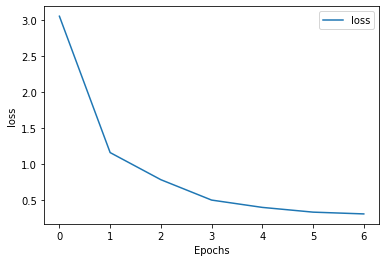

In [17]:
plot_graphs(history,'loss')

In [31]:
model.save('saves\\tf_lstmmodel') 
json_string = tokenizer.to_json()

INFO:tensorflow:Assets written to: saves\tf_lstmmodel\assets


In [19]:
import json
with open('saves\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [20]:
with open('saves\\tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
pred = model.predict(x_test)

In [22]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [23]:
mpl.rcParams['figure.figsize'] = (10, 8)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

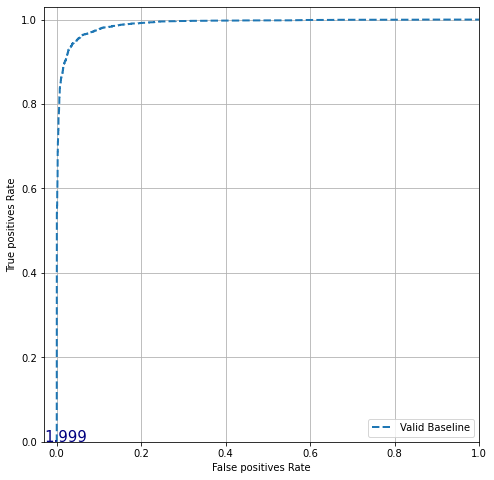

In [24]:
plot_roc("Valid Baseline", test_labels, pred, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [25]:
from sklearn.metrics import classification_report

pred = model.predict(x_test)
pred = [1 if pred[x]>0.85 else 0 for x in range(len(pred))]
print(classification_report(y_test,pred,target_names=['Not Clickbait','Clickbait']))

               precision    recall  f1-score   support

Not Clickbait       0.90      0.98      0.94      4016
    Clickbait       0.98      0.89      0.93      3984

     accuracy                           0.94      8000
    macro avg       0.94      0.94      0.94      8000
 weighted avg       0.94      0.94      0.94      8000



In [26]:
hero.clean(pd.Series(['You wont believe this'])).tolist()

['wont believe']

In [30]:
model.predict(x_test)

array([[0.00179681],
       [0.9785346 ],
       [0.9983684 ],
       ...,
       [0.36935776],
       [0.01496202],
       [0.9937428 ]], dtype=float32)